In [1]:
import os
import cmdstanpy
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import describe, gaussian_kde, norm, expon
import multiprocessing
import seaborn as sns
import warnings
import time

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 14

In [3]:
from thinning import sample_hawkes_process_thinning_true_vectorised
from utils import exp_kernel_vectorised, constant_background, plot_counting_process
from mle import log_likelihood
from utils import trace_plots, posterior_histograms, posterior_kdes_overlaid, stacked_credible_intervals

In [51]:
np.random.SeedSequence()

SeedSequence(
    entropy=43526238385608073352718321501689842867,
)

## Increasing period of observation

Now we will investigate how our inference improves as we increase the window of observation.

To simplify things, we will fix mu and alpha as their true values and only perform inference on delta.

### Checking sensible max_T values

In [4]:
stan_file = os.path.join('.', 'models', 'exponential_priors_delta_only.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

17:05:59 - cmdstanpy - INFO - compiling stan file C:\Users\ethan\ONEDRI~1\Maths\YEAR4~1\Project\HAWKES~1\BAYESI~1\models\exponential_priors_delta_only.stan to exe file C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\models\exponential_priors_delta_only.exe
17:06:18 - cmdstanpy - INFO - compiled model executable: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\models\exponential_priors_delta_only.exe


In [6]:
hawkes_seed=81123867819014675093953765794895738137

max_T = 400
hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=hawkes_seed)
N = len(hawkes_realisation)

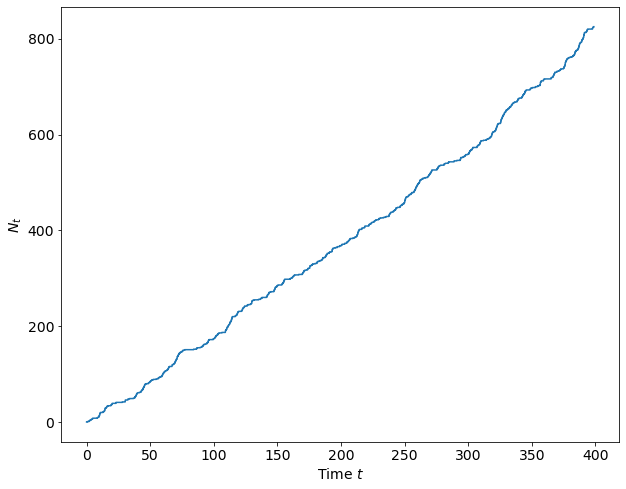

In [7]:
plot_counting_process(hawkes_realisation)

In [8]:
data = {
    "N" : N,
    "events_list" : hawkes_realisation,
    "max_T" : max_T
}

In [9]:
warmup = 250

fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits="0",
                            save_warmup=True)

17:06:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:09:48 - cmdstanpy - INFO - CmdStan done processing.


In [10]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-139.29500,0.023303,0.675844,-140.65200,-139.03000,-138.84800,841.134,3.58752,0.99973
delta,1.98777,0.005119,0.115469,1.79445,1.98556,2.18267,508.812,2.17014,1.00037


In [11]:
print(fit.diagnose())

Processing csv files: C:\Users\ethan\AppData\Local\Temp\tmp3493fqb0\exponential_priors_delta_onlyw_w599rk\exponential_priors_delta_only-20240422170656_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\AppData\Local\Temp\tmp3493fqb0\exponential_priors_delta_onlyw_w599rk\exponential_priors_delta_only-20240422170656_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



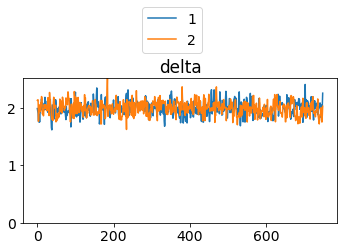

In [14]:
trace_plots([fit], ['delta'], legend_height=1.2)

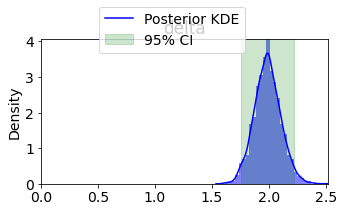

In [15]:
posterior_histograms([fit], ['delta'])

In [32]:
T = 100
index = np.searchsorted(hawkes_realisation, T)
h = hawkes_realisation[:index]
n = len(h)

data = {
    "N" : n,
    "events_list" : h,
    "max_T" : T
}

In [33]:
warmup = 250

fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits="0",
                            save_warmup=True)

17:15:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:15:18 - cmdstanpy - INFO - CmdStan done processing.


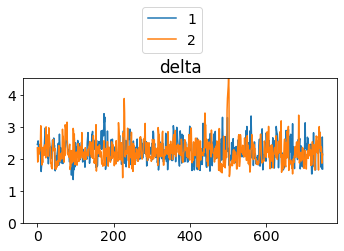

In [36]:
trace_plots([fit], ['delta'], legend_height=1.2)

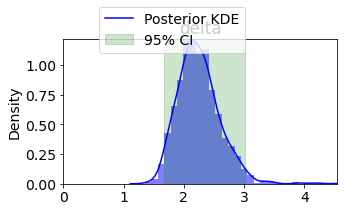

In [37]:
posterior_histograms([fit], ['delta'])

In [38]:
hawkes_seed=81123867819014675093953765794895738137

max_T = 500
hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=hawkes_seed)
N = len(hawkes_realisation)

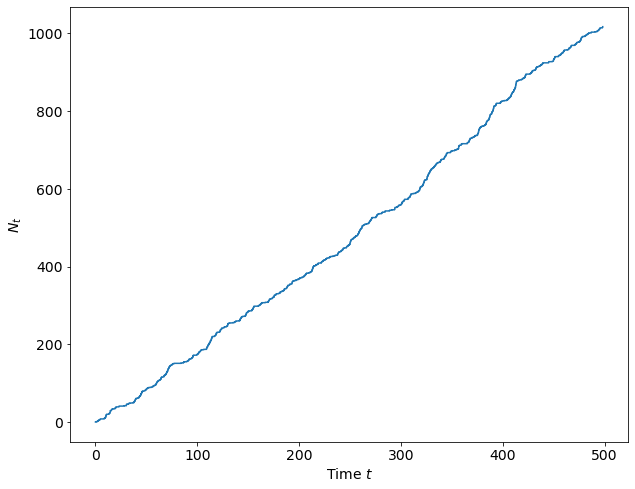

In [42]:
plot_counting_process(hawkes_realisation)

In [43]:
data = {
    "N" : N,
    "events_list" : hawkes_realisation,
    "max_T" : max_T
}

In [44]:
warmup = 250

fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits="0",
                            save_warmup=True)

17:17:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:21:52 - cmdstanpy - INFO - CmdStan done processing.


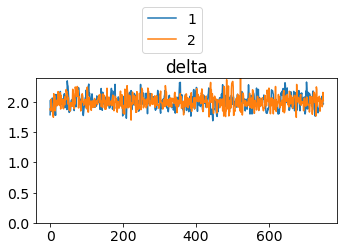

In [45]:
trace_plots([fit], ['delta'], legend_height=1.2)

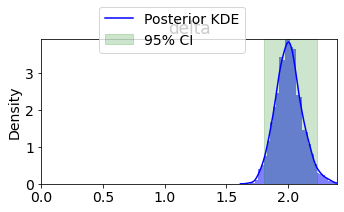

In [46]:
posterior_histograms([fit], ['delta'])

### Now doing for multiple realisations

For ease, we will run each value of max_T separately. Shouldn't be too much effort.

We will just make sure to re-use the seeds for generating the realisations and doing the MCMC sampling

#### max_T=100

In [47]:
max_T = 100
num_samples = 10
hawkes_realisations = []

master_seed = 37789148086743724264404479032151903001
seed_seq_master = np.random.SeedSequence(master_seed)

for i in range(num_samples):

    child_seed = seed_seq_master.spawn(1)[0]

    hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=child_seed)
    hawkes_realisations.append(hawkes_realisation)

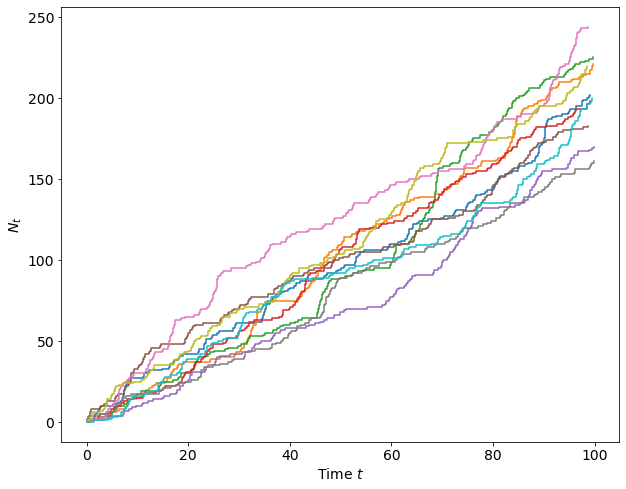

In [48]:
for h in hawkes_realisations:
    h = [0] + h
    counts = np.arange(len(h))
    plt.step(h, counts, where='post')
plt.xlabel("Time $t$")
plt.ylabel("$N_t$")
plt.show()

In [49]:
data_list = [{
    "N" : len(h),
    "events_list" : h,
    "max_T" : max_T
} for h in hawkes_realisations]

In [53]:
warmup = 250

master_seed_stan = 43526238385608073352718321501689842867
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits = []

save_dir = os.path.join('.', 'saved_fits', 'exponential_priors_delta_only', f'max_T={max_T}')

for i in range(num_samples):
    print(f"MCMC sampling for realisation {i}")

    child_seed_stan = seed_seq_master_stan.spawn(1)[0]

    # Create a random number generator using the seed
    rng = np.random.default_rng(child_seed_stan)
    
    # Generate random integers less than 2**32 - 1
    child_seed = rng.integers(2**32 - 1)
    print(f"Child seed used = {child_seed}")

    save_path = os.path.join(save_dir, f"realisation{i}")
    print(f"Saving to {save_path}")

    fit = model_compiled.sample(data=data_list[i],
                                seed=child_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits="0",
                                save_warmup=True,
                                output_dir=save_path)
    
    fits.append(fit)

17:26:59 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=100\realisation0
17:26:59 - cmdstanpy - INFO - CmdStan start processing


MCMC sampling for realisation 0
Child seed used = 1335997441
Saving to .\saved_fits\exponential_priors_delta_only\max_T=100\realisation0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:27:10 - cmdstanpy - INFO - CmdStan done processing.
17:27:10 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=100\realisation1
17:27:10 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 1
Child seed used = 3161308824
Saving to .\saved_fits\exponential_priors_delta_only\max_T=100\realisation1


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:27:22 - cmdstanpy - INFO - CmdStan done processing.
17:27:22 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=100\realisation2
17:27:22 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 2
Child seed used = 157769519
Saving to .\saved_fits\exponential_priors_delta_only\max_T=100\realisation2


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:27:35 - cmdstanpy - INFO - CmdStan done processing.
17:27:35 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=100\realisation3
17:27:35 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 3
Child seed used = 1588878709
Saving to .\saved_fits\exponential_priors_delta_only\max_T=100\realisation3


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:27:46 - cmdstanpy - INFO - CmdStan done processing.
17:27:46 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=100\realisation4
17:27:46 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 4
Child seed used = 3919124237
Saving to .\saved_fits\exponential_priors_delta_only\max_T=100\realisation4


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:27:53 - cmdstanpy - INFO - CmdStan done processing.
17:27:53 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=100\realisation5
17:27:53 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 5
Child seed used = 2925522856
Saving to .\saved_fits\exponential_priors_delta_only\max_T=100\realisation5


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:28:03 - cmdstanpy - INFO - CmdStan done processing.
17:28:04 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=100\realisation6
17:28:04 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 6
Child seed used = 2963777707
Saving to .\saved_fits\exponential_priors_delta_only\max_T=100\realisation6


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:28:21 - cmdstanpy - INFO - CmdStan done processing.
17:28:21 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=100\realisation7
17:28:21 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 7
Child seed used = 842792797
Saving to .\saved_fits\exponential_priors_delta_only\max_T=100\realisation7


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:28:30 - cmdstanpy - INFO - CmdStan done processing.
17:28:30 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=100\realisation8
17:28:30 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 8
Child seed used = 1831251485
Saving to .\saved_fits\exponential_priors_delta_only\max_T=100\realisation8


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:28:45 - cmdstanpy - INFO - CmdStan done processing.
17:28:45 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=100\realisation9
17:28:45 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 9
Child seed used = 5509238
Saving to .\saved_fits\exponential_priors_delta_only\max_T=100\realisation9


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:28:54 - cmdstanpy - INFO - CmdStan done processing.


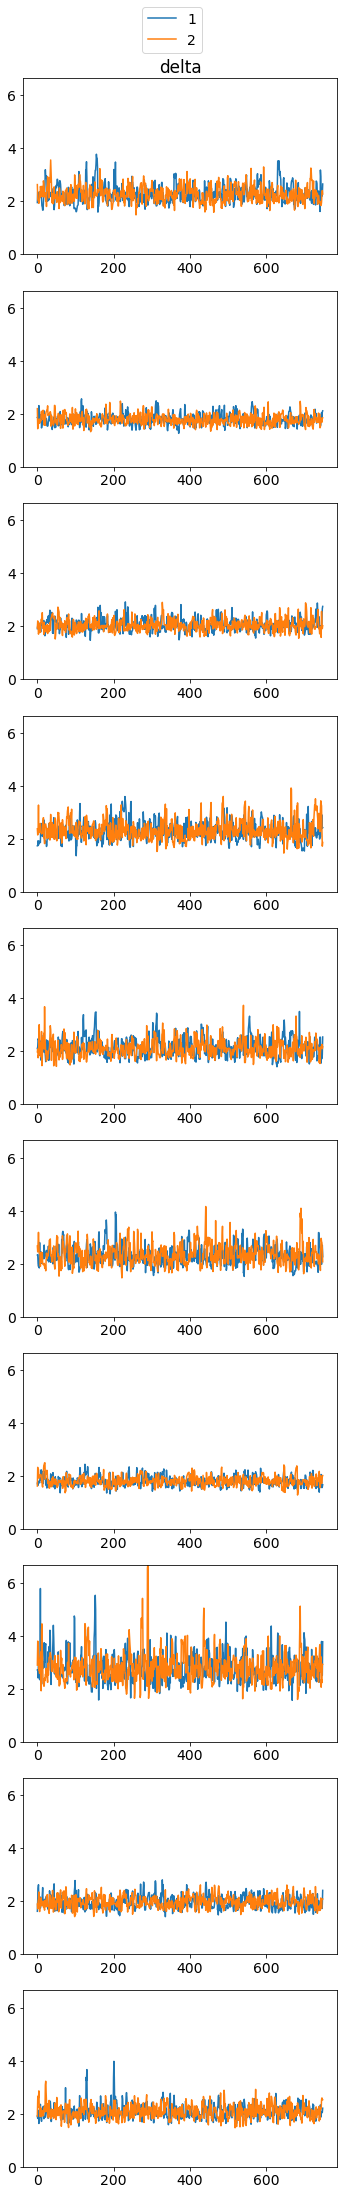

In [55]:
trace_plots(fits, ['delta'])

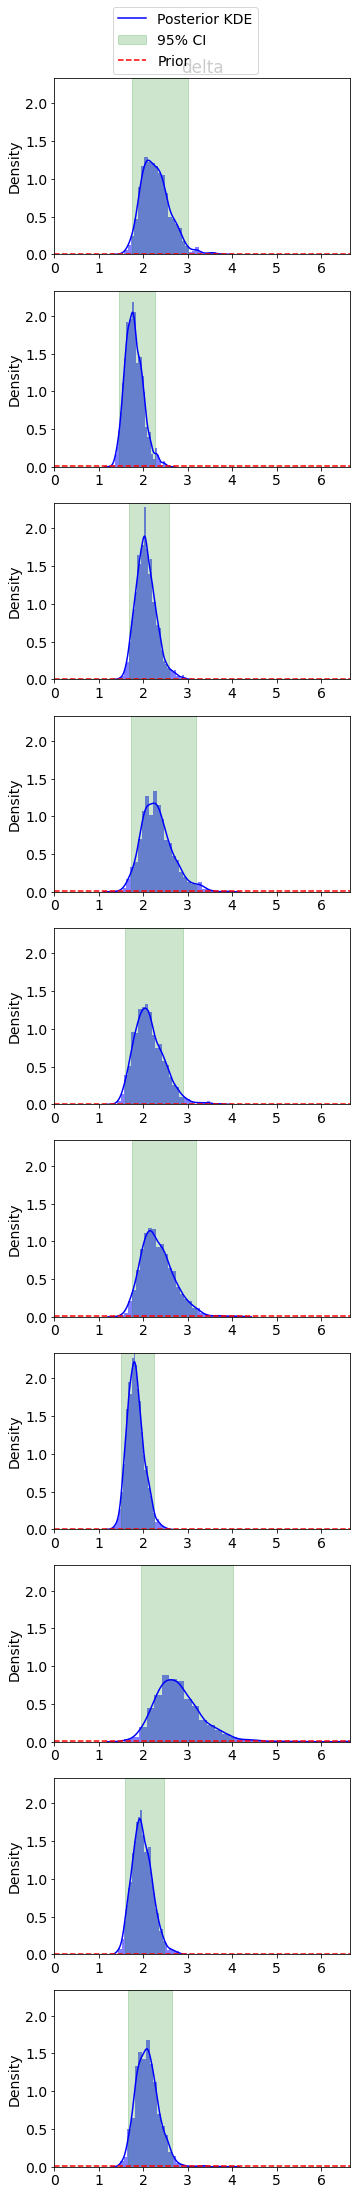

In [57]:
posterior_histograms(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

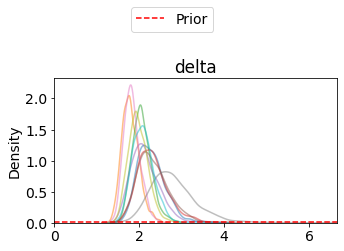

In [58]:
posterior_kdes_overlaid(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

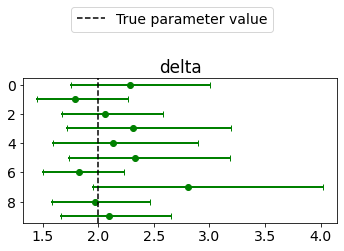

In [61]:
stacked_credible_intervals(fits, ['delta'], [2])

#### max_T=200

In [62]:
max_T = 200
num_samples = 10
hawkes_realisations = []

master_seed = 37789148086743724264404479032151903001
seed_seq_master = np.random.SeedSequence(master_seed)

for i in range(num_samples):

    child_seed = seed_seq_master.spawn(1)[0]

    hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=child_seed)
    hawkes_realisations.append(hawkes_realisation)

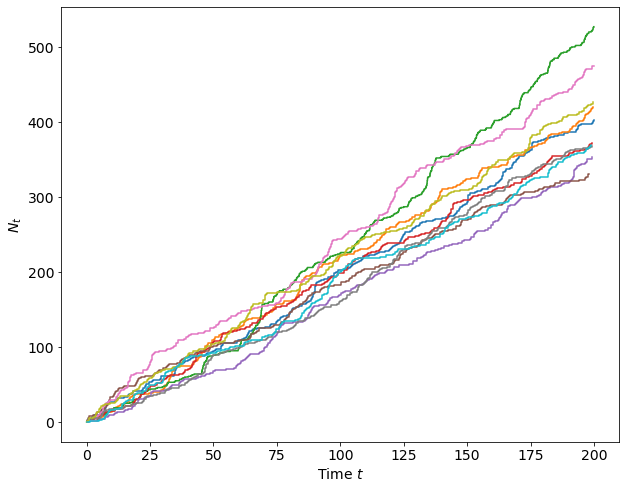

In [63]:
for h in hawkes_realisations:
    h = [0] + h
    counts = np.arange(len(h))
    plt.step(h, counts, where='post')
plt.xlabel("Time $t$")
plt.ylabel("$N_t$")
plt.show()

In [64]:
data_list = [{
    "N" : len(h),
    "events_list" : h,
    "max_T" : max_T
} for h in hawkes_realisations]

In [65]:
warmup = 250

master_seed_stan = 43526238385608073352718321501689842867
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits = []

save_dir = os.path.join('.', 'saved_fits', 'exponential_priors_delta_only', f'max_T={max_T}')

for i in range(num_samples):
    print(f"MCMC sampling for realisation {i}")

    child_seed_stan = seed_seq_master_stan.spawn(1)[0]

    # Create a random number generator using the seed
    rng = np.random.default_rng(child_seed_stan)
    
    # Generate random integers less than 2**32 - 1
    child_seed = rng.integers(2**32 - 1)
    print(f"Child seed used = {child_seed}")

    save_path = os.path.join(save_dir, f"realisation{i}")
    print(f"Saving to {save_path}")

    fit = model_compiled.sample(data=data_list[i],
                                seed=child_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits="0",
                                save_warmup=True,
                                output_dir=save_path)
    
    fits.append(fit)

17:32:26 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=200\realisation0
17:32:26 - cmdstanpy - INFO - CmdStan start processing


MCMC sampling for realisation 0
Child seed used = 1335997441
Saving to .\saved_fits\exponential_priors_delta_only\max_T=200\realisation0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:33:16 - cmdstanpy - INFO - CmdStan done processing.
17:33:16 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=200\realisation1
17:33:16 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 1
Child seed used = 3161308824
Saving to .\saved_fits\exponential_priors_delta_only\max_T=200\realisation1


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:34:15 - cmdstanpy - INFO - CmdStan done processing.
17:34:15 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=200\realisation2
17:34:15 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 2
Child seed used = 157769519
Saving to .\saved_fits\exponential_priors_delta_only\max_T=200\realisation2


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:35:37 - cmdstanpy - INFO - CmdStan done processing.
17:35:37 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=200\realisation3
17:35:37 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 3
Child seed used = 1588878709
Saving to .\saved_fits\exponential_priors_delta_only\max_T=200\realisation3


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:36:21 - cmdstanpy - INFO - CmdStan done processing.
17:36:21 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=200\realisation4



MCMC sampling for realisation 4
Child seed used = 3919124237
Saving to .\saved_fits\exponential_priors_delta_only\max_T=200\realisation4


17:36:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:36:59 - cmdstanpy - INFO - CmdStan done processing.
17:36:59 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=200\realisation5
17:36:59 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 5
Child seed used = 2925522856
Saving to .\saved_fits\exponential_priors_delta_only\max_T=200\realisation5


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:37:36 - cmdstanpy - INFO - CmdStan done processing.
17:37:36 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=200\realisation6
17:37:36 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 6
Child seed used = 2963777707
Saving to .\saved_fits\exponential_priors_delta_only\max_T=200\realisation6


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:38:51 - cmdstanpy - INFO - CmdStan done processing.
17:38:51 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=200\realisation7
17:38:51 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 7
Child seed used = 842792797
Saving to .\saved_fits\exponential_priors_delta_only\max_T=200\realisation7


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:39:37 - cmdstanpy - INFO - CmdStan done processing.
17:39:37 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=200\realisation8
17:39:37 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 8
Child seed used = 1831251485
Saving to .\saved_fits\exponential_priors_delta_only\max_T=200\realisation8


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:40:41 - cmdstanpy - INFO - CmdStan done processing.
17:40:41 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=200\realisation9
17:40:41 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 9
Child seed used = 5509238
Saving to .\saved_fits\exponential_priors_delta_only\max_T=200\realisation9


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:41:25 - cmdstanpy - INFO - CmdStan done processing.


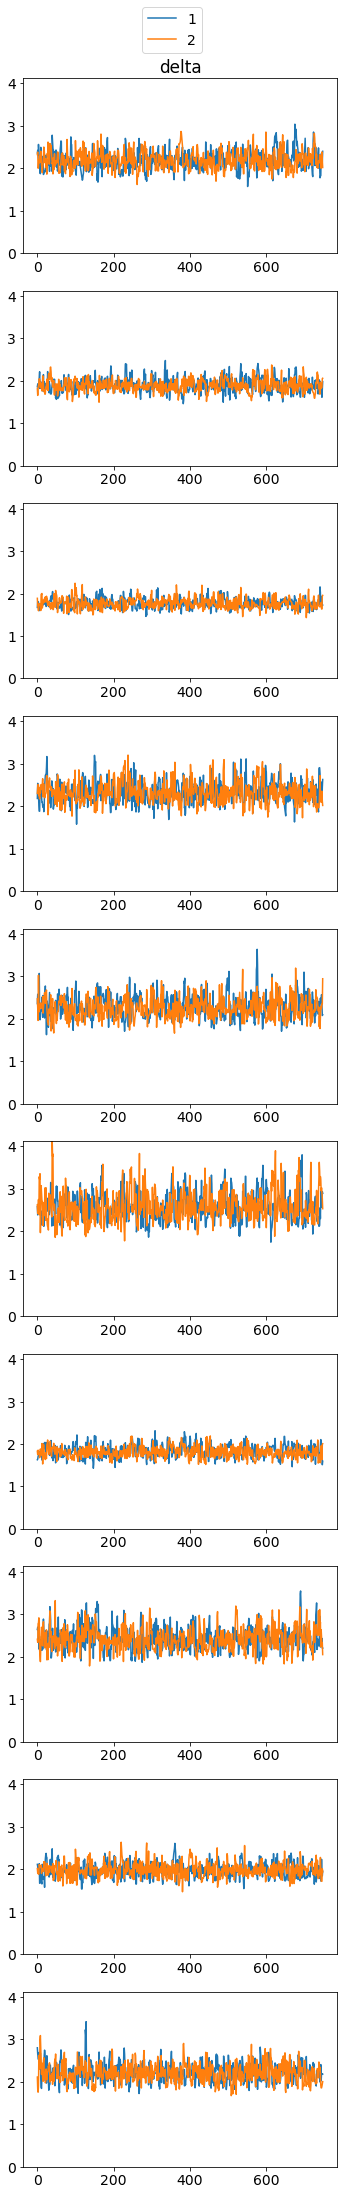

In [66]:
trace_plots(fits, ['delta'])

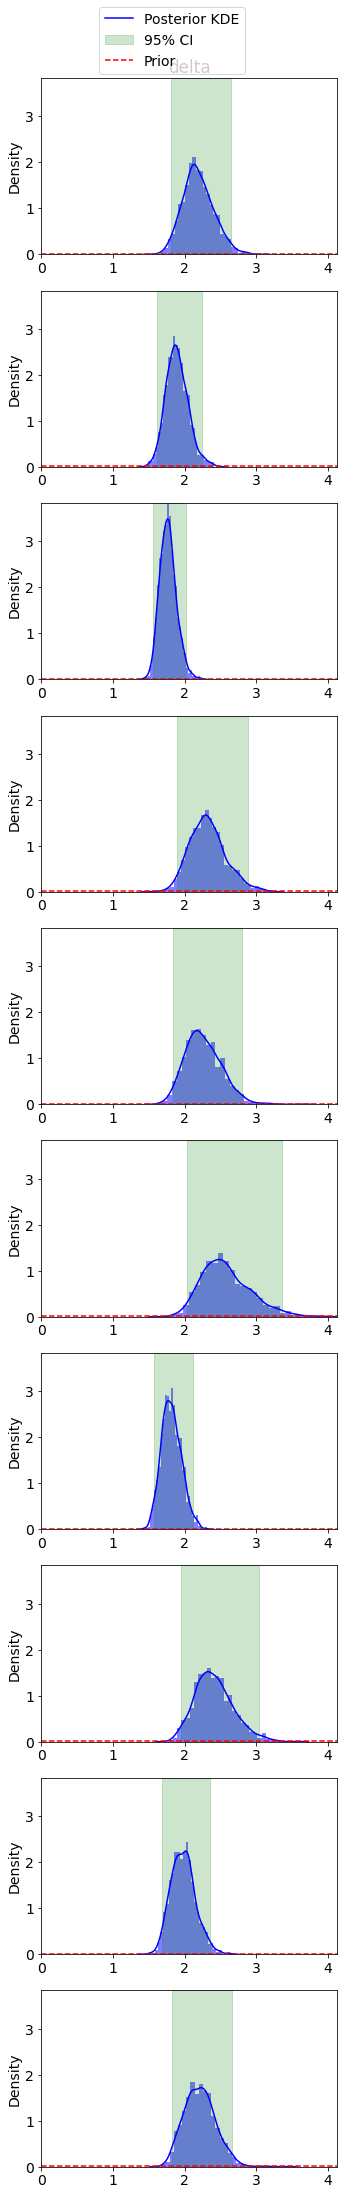

In [67]:
posterior_histograms(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

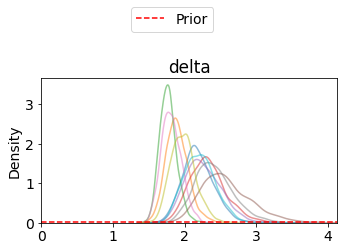

In [68]:
posterior_kdes_overlaid(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

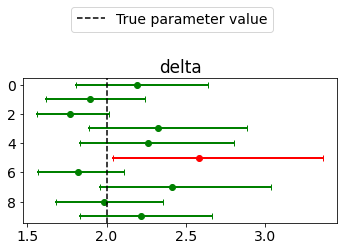

In [69]:
stacked_credible_intervals(fits, ['delta'], [2])

#### max_T=300

In [70]:
max_T = 300
num_samples = 10
hawkes_realisations = []

master_seed = 37789148086743724264404479032151903001
seed_seq_master = np.random.SeedSequence(master_seed)

for i in range(num_samples):

    child_seed = seed_seq_master.spawn(1)[0]

    hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=child_seed)
    hawkes_realisations.append(hawkes_realisation)

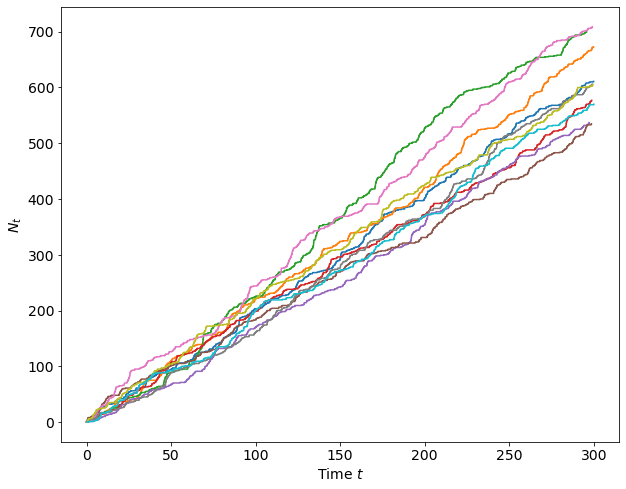

In [71]:
for h in hawkes_realisations:
    h = [0] + h
    counts = np.arange(len(h))
    plt.step(h, counts, where='post')
plt.xlabel("Time $t$")
plt.ylabel("$N_t$")
plt.show()

In [72]:
data_list = [{
    "N" : len(h),
    "events_list" : h,
    "max_T" : max_T
} for h in hawkes_realisations]

In [73]:
warmup = 250

master_seed_stan = 43526238385608073352718321501689842867
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits = []

save_dir = os.path.join('.', 'saved_fits', 'exponential_priors_delta_only', f'max_T={max_T}')

for i in range(num_samples):
    print(f"MCMC sampling for realisation {i}")

    child_seed_stan = seed_seq_master_stan.spawn(1)[0]

    # Create a random number generator using the seed
    rng = np.random.default_rng(child_seed_stan)
    
    # Generate random integers less than 2**32 - 1
    child_seed = rng.integers(2**32 - 1)
    print(f"Child seed used = {child_seed}")

    save_path = os.path.join(save_dir, f"realisation{i}")
    print(f"Saving to {save_path}")

    fit = model_compiled.sample(data=data_list[i],
                                seed=child_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits="0",
                                save_warmup=True,
                                output_dir=save_path)
    
    fits.append(fit)

17:43:46 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=300\realisation0
17:43:46 - cmdstanpy - INFO - CmdStan start processing


MCMC sampling for realisation 0
Child seed used = 1335997441
Saving to .\saved_fits\exponential_priors_delta_only\max_T=300\realisation0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:47:28 - cmdstanpy - INFO - CmdStan done processing.
17:47:28 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=300\realisation1
17:47:28 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 1
Child seed used = 3161308824
Saving to .\saved_fits\exponential_priors_delta_only\max_T=300\realisation1


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:49:53 - cmdstanpy - INFO - CmdStan done processing.
17:49:54 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=300\realisation2
17:49:54 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 2
Child seed used = 157769519
Saving to .\saved_fits\exponential_priors_delta_only\max_T=300\realisation2


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:55:08 - cmdstanpy - INFO - CmdStan done processing.
17:55:08 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=300\realisation3
17:55:08 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 3
Child seed used = 1588878709
Saving to .\saved_fits\exponential_priors_delta_only\max_T=300\realisation3


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:59:34 - cmdstanpy - INFO - CmdStan done processing.
17:59:34 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=300\realisation4
17:59:34 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 4
Child seed used = 3919124237
Saving to .\saved_fits\exponential_priors_delta_only\max_T=300\realisation4


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

18:03:28 - cmdstanpy - INFO - CmdStan done processing.
18:03:28 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=300\realisation5
18:03:28 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 5
Child seed used = 2925522856
Saving to .\saved_fits\exponential_priors_delta_only\max_T=300\realisation5


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

18:07:16 - cmdstanpy - INFO - CmdStan done processing.


18:07:16 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=300\realisation6
18:07:16 - cmdstanpy - INFO - CmdStan start processing


MCMC sampling for realisation 6
Child seed used = 2963777707
Saving to .\saved_fits\exponential_priors_delta_only\max_T=300\realisation6


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

18:15:16 - cmdstanpy - INFO - CmdStan done processing.
18:15:16 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=300\realisation7
18:15:16 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 7
Child seed used = 842792797
Saving to .\saved_fits\exponential_priors_delta_only\max_T=300\realisation7


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

18:21:00 - cmdstanpy - INFO - CmdStan done processing.
18:21:00 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=300\realisation8
18:21:00 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 8
Child seed used = 1831251485
Saving to .\saved_fits\exponential_priors_delta_only\max_T=300\realisation8


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

18:24:17 - cmdstanpy - INFO - CmdStan done processing.
18:24:17 - cmdstanpy - INFO - created output directory: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\saved_fits\exponential_priors_delta_only\max_T=300\realisation9
18:24:17 - cmdstanpy - INFO - CmdStan start processing



MCMC sampling for realisation 9
Child seed used = 5509238
Saving to .\saved_fits\exponential_priors_delta_only\max_T=300\realisation9


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

18:26:02 - cmdstanpy - INFO - CmdStan done processing.


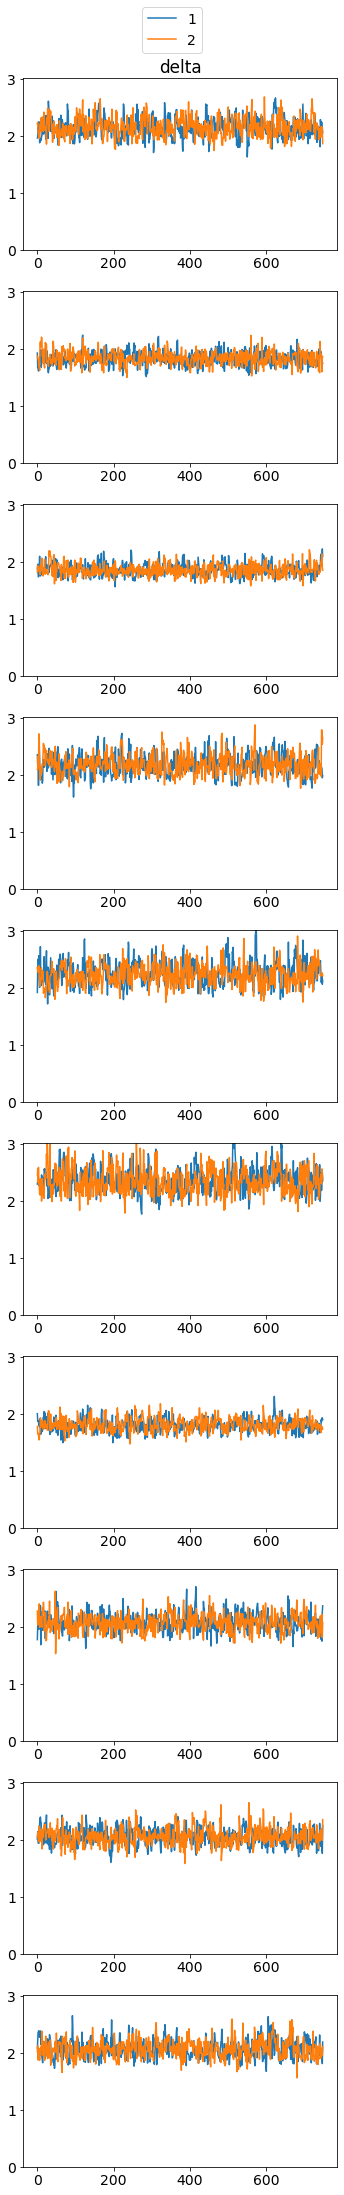

In [74]:
trace_plots(fits, ['delta'])

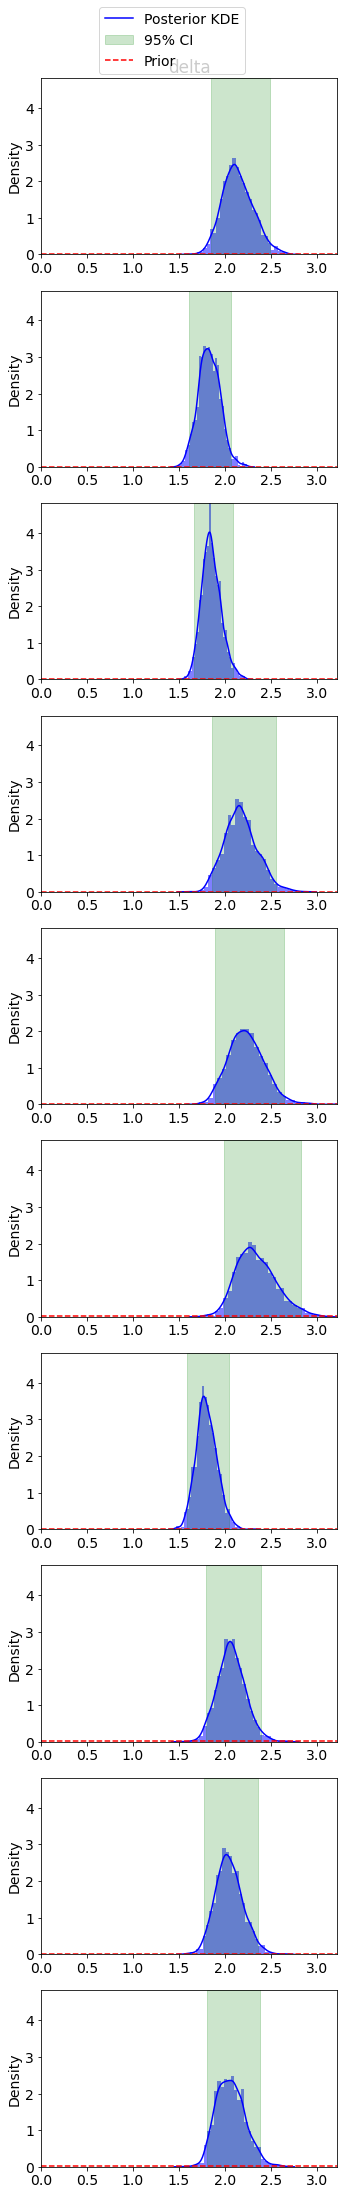

In [75]:
posterior_histograms(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

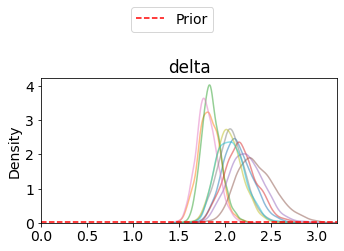

In [76]:
posterior_kdes_overlaid(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

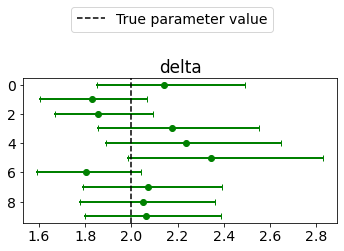

In [77]:
stacked_credible_intervals(fits, ['delta'], [2])

Sidenote: max_T=300 took 45 mins to run.

Let's try and plot the posteriors of each realisation altogether.

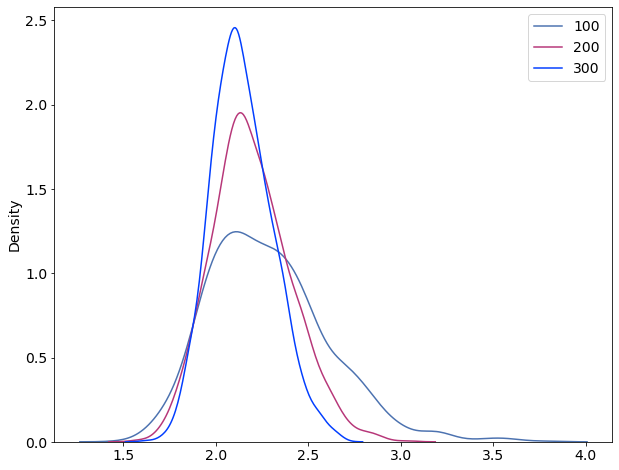

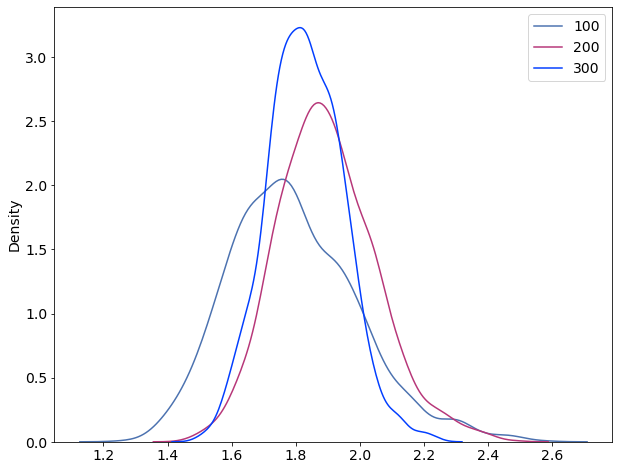

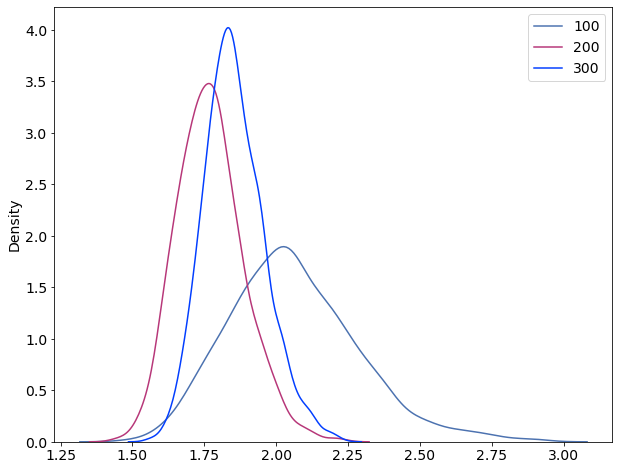

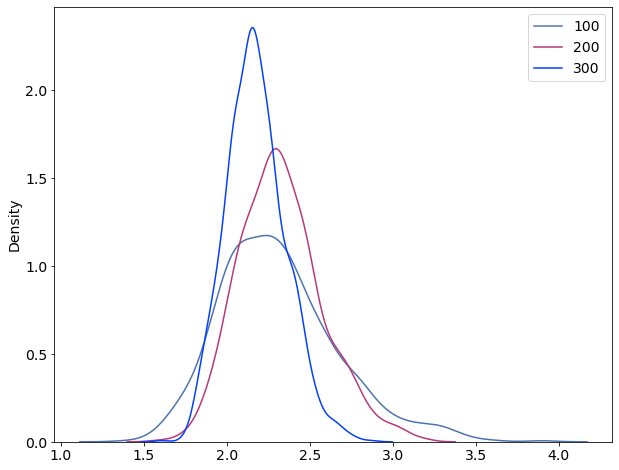

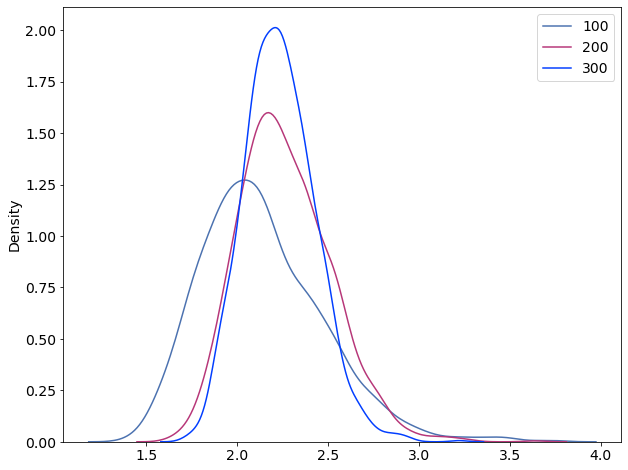

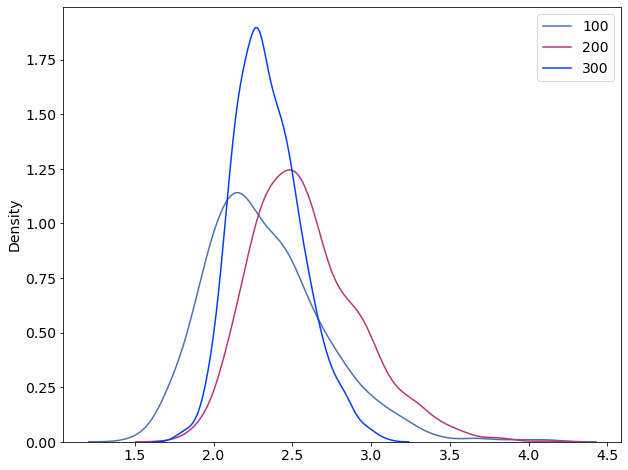

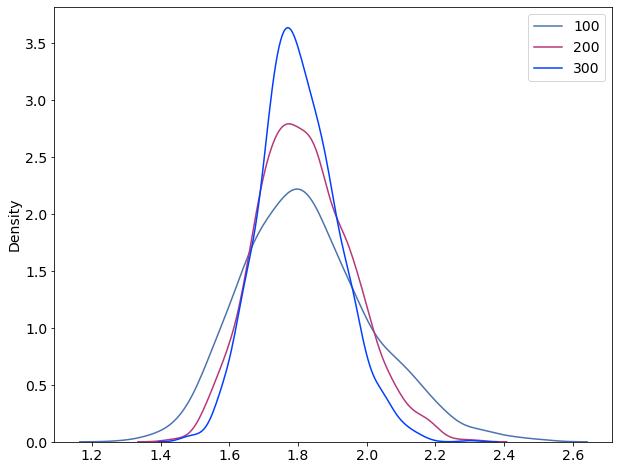

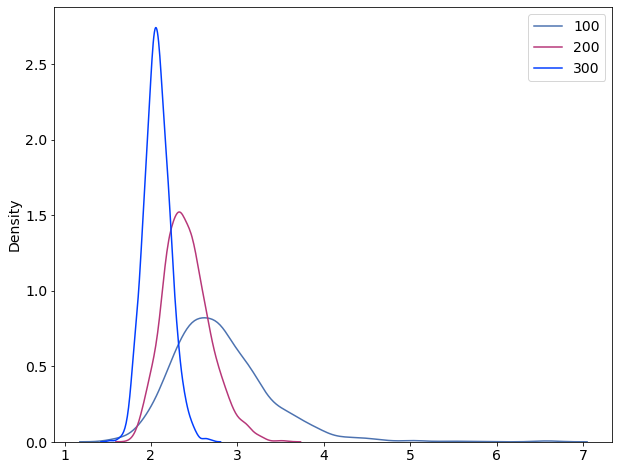

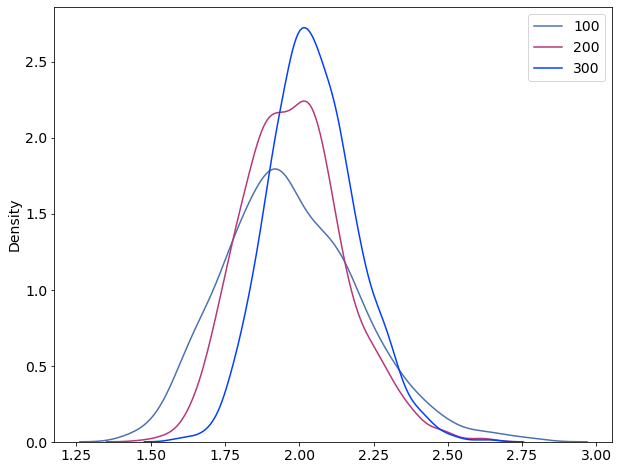

In [90]:
for j in range(9):
    colors = ['deep','magma','bright']
    for i, T in enumerate([100, 200, 300]):
        save_dir = os.path.join('.', 'saved_fits', 'exponential_priors_delta_only', f'max_T={T}')
        save_path = os.path.join(save_dir, f'realisation{j}')
        fit = cmdstanpy.from_csv(save_path)
        df = fit.draws_pd('delta')
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            sns.kdeplot(df, palette=colors[i], label=T)
    plt.legend()
    plt.show()